In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import frangi
from scipy.ndimage import minimum_filter, maximum_filter
import pandas as pd


In [2]:
def show(*args):
    images = len(args)
    rows = int(np.ceil(images / 5.0))   
    cols = min(5, images)              

    fig, ax = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))

    for i, img in enumerate(args):
        if rows == 1:  
            if cols == 1: 
                ax.imshow(img, cmap='gray')
            else:  
                ax[i].imshow(img, cmap='gray')
        else: 
            row = i // 5
            col = i % 5
            ax[row, col].imshow(img, cmap='gray')

    if images < rows * cols:
        for i in range(images, rows * cols):
            fig.delaxes(ax.flatten()[i])
    plt.tight_layout()
    plt.show()

In [3]:
def enhance_contrast(layer):
    if layer.dtype != np.uint8:
        layer = cv2.normalize(layer, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    equalized = cv2.equalizeHist(layer)
    return equalized

def emphasize_boundaries(layer):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    eroded = cv2.erode(layer, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    return dilated

def combine_layers(layers):
    combined = np.maximum.reduce(layers)
    combined = cv2.normalize(combined, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return combined

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    stacked_layers = cv2.split(image)
    tiff_stack = cv2.imreadmulti(image_path)[1]
    enhanced_layers = []
    for layer in stacked_layers:
        enhanced = enhance_contrast(layer)
        emphasized = emphasize_boundaries(enhanced)
        enhanced_layers.append(emphasized)

    bounded_img = tiff_stack[-1] - tiff_stack[1]
    bounded_img = cv2.GaussianBlur(bounded_img, (35,35), 10)
    bounded_img[bounded_img > 0] = 255

    final_output = combine_layers(enhanced_layers)        
    final_output[bounded_img == 0] = 0
    return final_output

def gamma_correction(img, gamma):
    return (np.power(img, gamma))*255

In [4]:
def equalize_hist(img):
    hist, bins = np.histogram(img.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    
    img_out = cdf[img.flatten().astype('uint8')]
    img_out = np.reshape(img_out, img.shape)

    return img_out

def normalize(img):
    return (img - np.min(img))/(np.max(img)- np.min(img))*255

def convert_gray_to_rgb(image):
    image_rgb = np.stack((image,)*3, axis=-1)
    return image_rgb

def threshold_image(image, threshold=10, max_value=255):
    thresholded_image = np.where(image > threshold, max_value, 0).astype('uint8')
    return thresholded_image

In [5]:
def create_cell_mask(thresh, min_fiber_length = 50):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)

    cells_mask = np.zeros_like(thresh)

    for i in range(1, num_labels):
        if max(stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]) > min_fiber_length:
            cells_mask[labels == i] = 255
    return cells_mask

## Load image 1/4

In [104]:
def image1_func():
    # Load image and normalize it
    image1 = process_image("pic1.TIF") / 255
    gamma = 3
    correct_image = gamma_correction(image1, gamma)
    image1_fibers = cv2.normalize(gamma_correction(image1, 2), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_image = cv2.normalize(correct_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Detect Cell borders
    blur = cv2.GaussianBlur(normalized_image, (7,)*2, 0)
    ret, thresh = cv2.threshold(blur, 80, 255, cv2.THRESH_BINARY_INV)
    _, outer_line = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV)
    outer_line = maximum_filter(outer_line, 60)
    
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open)
    
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)

    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open)

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)
    
    cells_mask = create_cell_mask(thresh)
    
    shape = cv2.MORPH_ELLIPSE
    kernel_size = (3,)*2
    kernel = cv2.getStructuringElement(shape, kernel_size)
    cells_mask = cv2.erode(cells_mask, kernel, iterations=2)

    kernel_size = (10,)*2
    kernel = cv2.getStructuringElement(shape, kernel_size)
    cells_mask = cv2.dilate(cells_mask, kernel)

    test = image1_fibers.copy()
    test[cells_mask == 0] = 0
    test[image1_fibers <= 30]=0
    
    # Apply filter to find fibers
    equalized_image = equalize_hist(test)   
    filtered_frangi = frangi(normalized_image, np.arange(0.7,5, 0.8), black_ridges=False)    
    filtered_frangi[cells_mask == 0] = 0  
    filtered_frangi[outer_line > 0] = 0  
    filtered_frangi =  minimum_filter(filtered_frangi, 2)
    ed_frangi = cv2.dilate(filtered_frangi, (10,)*2)
    ed_frangi = cv2.erode(ed_frangi, (5,)*2)

    ed_frangi = cv2.dilate(ed_frangi, (9,)*2)
    ed_frangi = cv2.erode(ed_frangi, (3,)*2)

    ed_frangi = cv2.erode(ed_frangi, (5,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (5,)*2)

    ed_frangi = cv2.erode(ed_frangi, (15,)*2)

    normalized_image_frangi = cv2.normalize(ed_frangi, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = normalized_image_frangi
    eq_image = cv2.equalizeHist(image)
    
    equalized_image2 = equalize_hist(normalized_image)

    image_color = convert_gray_to_rgb(equalized_image)

    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image1 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)

    image_color = convert_gray_to_rgb(equalized_image2)

    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image2 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)
 
    show(highlighted_image1,normalized_image,  highlighted_image2, eq_image)
    

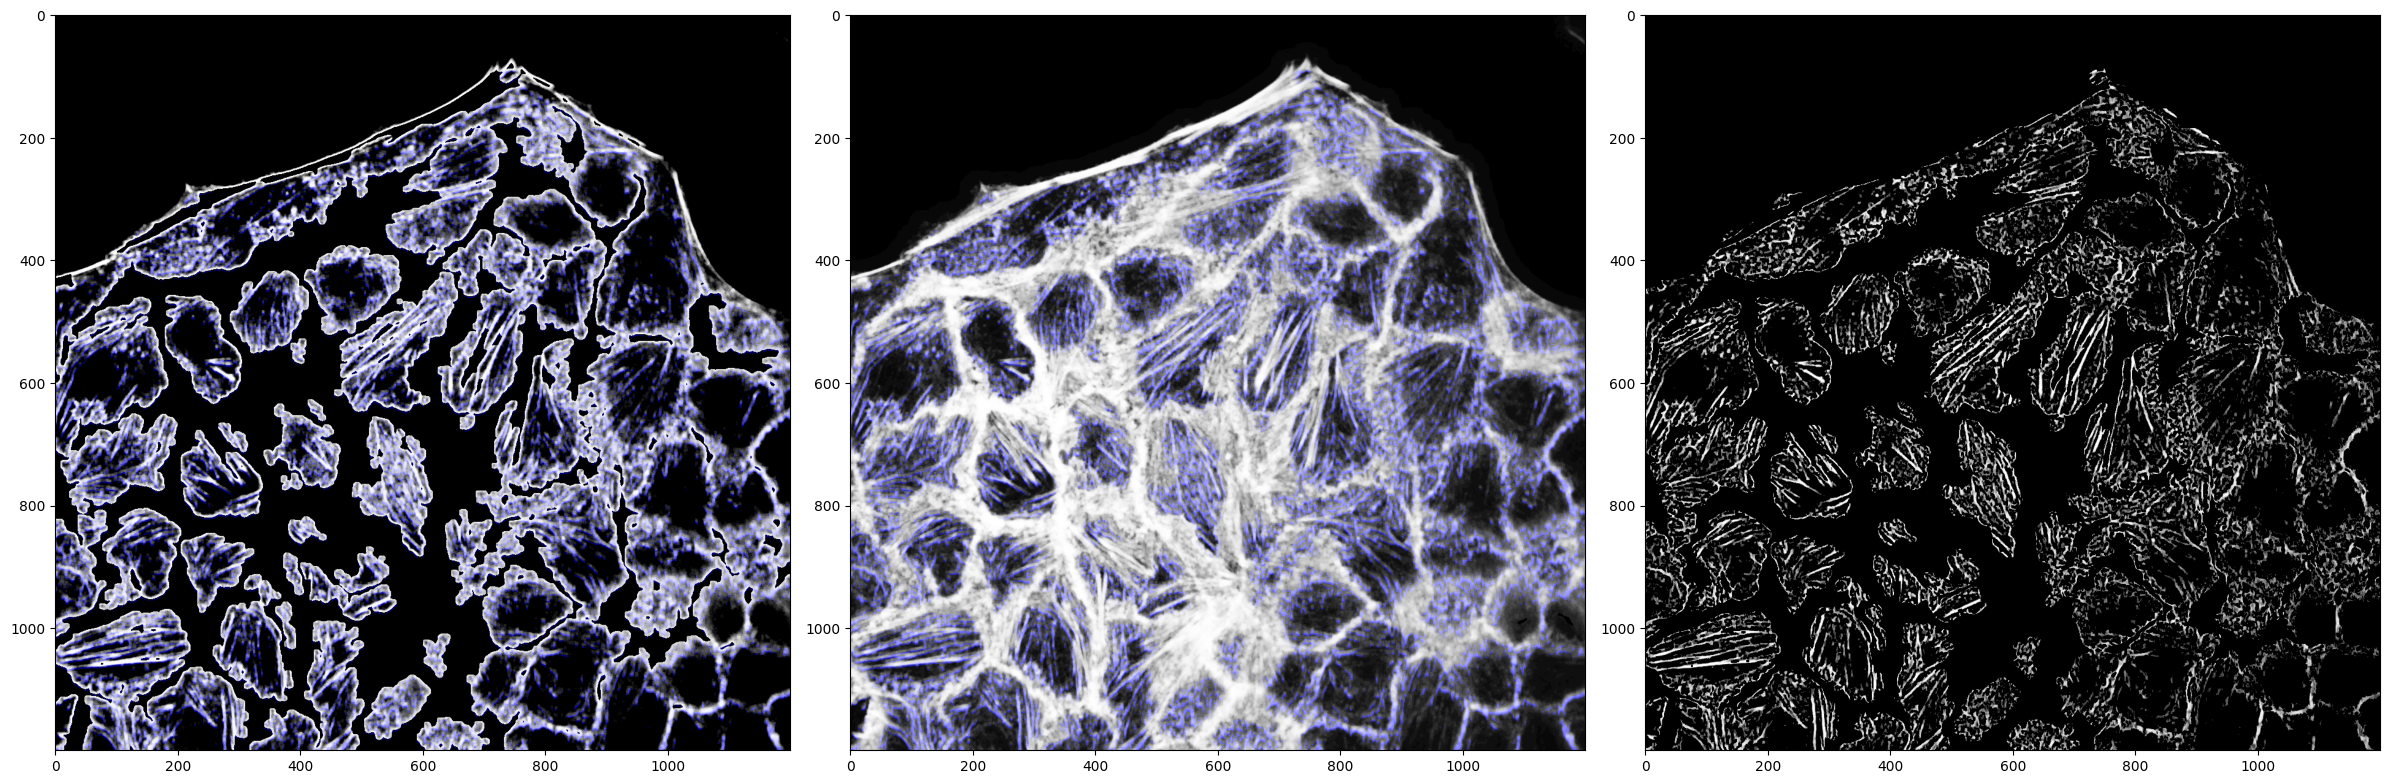

In [105]:
image1_func()

In [ ]:
def image2_func():
    image = process_image("pic2.TIF") / 255
    gamma = 3
    correct_image = gamma_correction(image, gamma)
    image1_fibers = cv2.normalize(gamma_correction(image, 2), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_image = cv2.normalize(correct_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Detect Cell borders
    blur = cv2.GaussianBlur(normalized_image, (7,)*2, 0)
    ret, thresh = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY_INV)
    _, outer_line = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV)
    outer_line = maximum_filter(outer_line, 60)

    
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open)
    
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)

    cells_mask = create_cell_mask(thresh)

    shape = cv2.MORPH_RECT
    kernel_size = (4,)*2
    kernel = cv2.getStructuringElement(shape, kernel_size)
    cells_mask = cv2.erode(cells_mask, kernel, iterations=2)
    
    kernel_size = (11,)*2
    kernel = cv2.getStructuringElement(shape, kernel_size)
    cells_mask = cv2.dilate(cells_mask, kernel)

    test = image1_fibers.copy()
    test[cells_mask == 0] = 0
    test[image1_fibers <= 30]=0

    equalized_image = equalize_hist(test)   
    filtered_frangi = frangi(normalized_image, np.arange(0.5,3, 1.5), beta=0.3, black_ridges=False)

    filtered_frangi[cells_mask == 0] = 0  
    filtered_frangi[outer_line > 0] = 0  
    filtered_frangi = minimum_filter(filtered_frangi, 2)  
    ed_frangi = cv2.dilate(filtered_frangi, (10,)*2)
    ed_frangi = cv2.erode(ed_frangi, (5,)*2)

    ed_frangi = cv2.dilate(ed_frangi, (9,)*2)
    ed_frangi = cv2.erode(ed_frangi, (3,)*2)

    ed_frangi = cv2.erode(ed_frangi, (5,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (5,)*2)

    ed_frangi = cv2.erode(ed_frangi, (15,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (5,)*2)

    
    normalized_image_frangi = cv2.normalize(ed_frangi, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = normalized_image_frangi


    eq_image = cv2.equalizeHist(image)

    equalized_image2 = equalize_hist(normalized_image)
    image_color = convert_gray_to_rgb(equalized_image)
    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image1 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)
    image_color = convert_gray_to_rgb(equalized_image2)
    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image2 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)

    show(highlighted_image1, normalized_image, highlighted_image2, eq_image)


In [ ]:
image2_func

In [53]:
def image3_func():
    image = process_image("pic3.TIF") / 255
    gamma = 3
    correct_image = gamma_correction(image, gamma)
    image1_fibers = cv2.normalize(gamma_correction(image, 2), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_image = cv2.normalize(correct_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Detect Cell borders
    blur = cv2.GaussianBlur(normalized_image, (7,)*2, 0)
    ret, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV)
    _, outer_line = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV)
    outer_line = maximum_filter(outer_line, 60)
    

    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open)

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)

    cells_mask = create_cell_mask(thresh, 30)

    shape = cv2.MORPH_RECT
    kernel_size = (5,)*2
    kernel = cv2.getStructuringElement(shape, kernel_size)
    cells_mask = cv2.erode(cells_mask, kernel, iterations=2)

    kernel_size = (13,)*2
    kernel = cv2.getStructuringElement(shape, kernel_size)
    cells_mask = cv2.dilate(cells_mask, kernel)

    test = image1_fibers.copy()
    test[cells_mask == 0] = 0
    test[image1_fibers <= 50]=0

    equalized_image = equalize_hist(test)   
    filtered_frangi = frangi(normalized_image, np.arange(5,10, 2), black_ridges=False)    
    filtered_frangi[cells_mask == 0] = 0  
    filtered_frangi[outer_line > 0] = 0  
    filtered_frangi = minimum_filter(filtered_frangi, 3)  
    ed_frangi = cv2.dilate(filtered_frangi, (10,)*2)
    ed_frangi = cv2.erode(ed_frangi, (5,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (9,)*2)
    ed_frangi = cv2.erode(ed_frangi, (3,)*2)
    ed_frangi = cv2.erode(ed_frangi, (5,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (5,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (5,)*2)

    kernel = cv2.getStructuringElement(shape, (5,)*2)
    ed_frangi = cv2.morphologyEx(ed_frangi, cv2.MORPH_CLOSE, kernel)
    ed_frangi = minimum_filter(ed_frangi, 3)  

    normalized_image_frangi = cv2.normalize(ed_frangi, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = normalized_image_frangi


    eq_image = cv2.equalizeHist(image)

    equalized_image2 = equalize_hist(normalized_image)
    image_color = convert_gray_to_rgb(equalized_image)
    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image1 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)
    image_color = convert_gray_to_rgb(equalized_image2)
    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image2 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)

    show(highlighted_image1, normalized_image, highlighted_image2, eq_image)

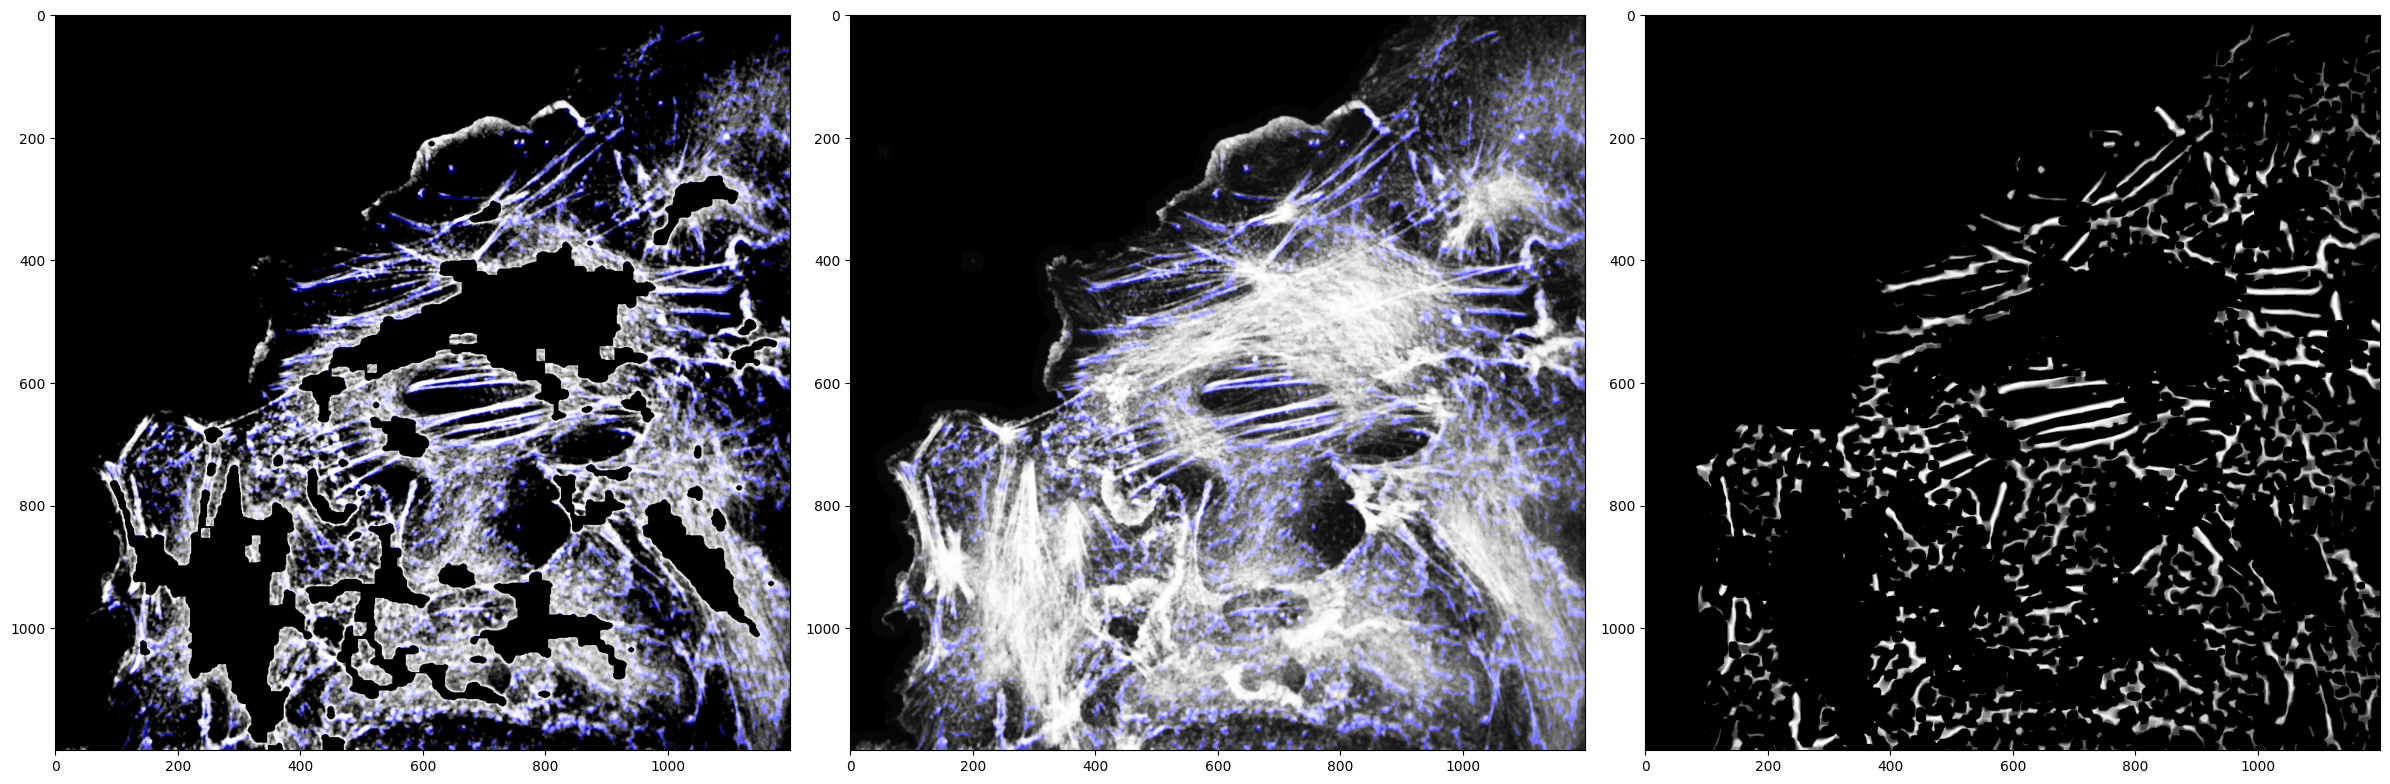

In [54]:
image3_func()

In [75]:
def image4_func():
    image = process_image("pic4.TIF") / 255
    gamma = 3
    correct_image = gamma_correction(image, gamma)
    image1_fibers = cv2.normalize(gamma_correction(image, 2), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_image = cv2.normalize(correct_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Detect Cell borders
    blur = cv2.GaussianBlur(normalized_image, (7,)*2, 0)
    ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY_INV)
    _, outer_line = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV)
    outer_line = maximum_filter(outer_line, 60)

    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open)

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)

    cells_mask = create_cell_mask(thresh)
    shape = cv2.MORPH_RECT
    kernel_size = (5,)*2
    kernel = cv2.getStructuringElement(shape, kernel_size)
    cells_mask = cv2.erode(cells_mask, kernel, iterations=2)
    kernel_size = (13,)*2
    kernel = cv2.getStructuringElement(shape, kernel_size)
    cells_mask = cv2.dilate(cells_mask, kernel)

    test = image1_fibers.copy()
    test[cells_mask == 0] = 0
    test[image1_fibers <= 60]=0

    equalized_image = equalize_hist(test)   
    filtered_frangi = frangi(normalized_image, np.arange(5,10, 2), black_ridges=False)    
    filtered_frangi[cells_mask == 0] = 0  
    filtered_frangi[outer_line > 0] = 0  
    filtered_frangi = minimum_filter(filtered_frangi, 3)  

    ed_frangi = cv2.dilate(filtered_frangi, (10,)*2)
    ed_frangi = cv2.erode(ed_frangi, (5,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (9,)*2)
    ed_frangi = cv2.erode(ed_frangi, (3,)*2)
    ed_frangi = cv2.erode(ed_frangi, (5,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (5,)*2)
    ed_frangi = cv2.dilate(ed_frangi, (5,)*2)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,)*2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)

    ed_frangi = minimum_filter(ed_frangi, 2)  
    normalized_image_frangi = cv2.normalize(ed_frangi, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = normalized_image_frangi

    eq_image = cv2.equalizeHist(image)
    equalized_image2 = equalize_hist(normalized_image)
    image_color = convert_gray_to_rgb(equalized_image)
    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image1 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)
    image_color = convert_gray_to_rgb(equalized_image2)
    color_mask = np.zeros_like(image_color)
    color_mask[eq_image > eq_image.mean()] = [0, 0, 255]
    highlighted_image2 = cv2.addWeighted(image_color, 1.0, color_mask, 0.5, 0)
    show(highlighted_image1,normalized_image,  highlighted_image2, eq_image)

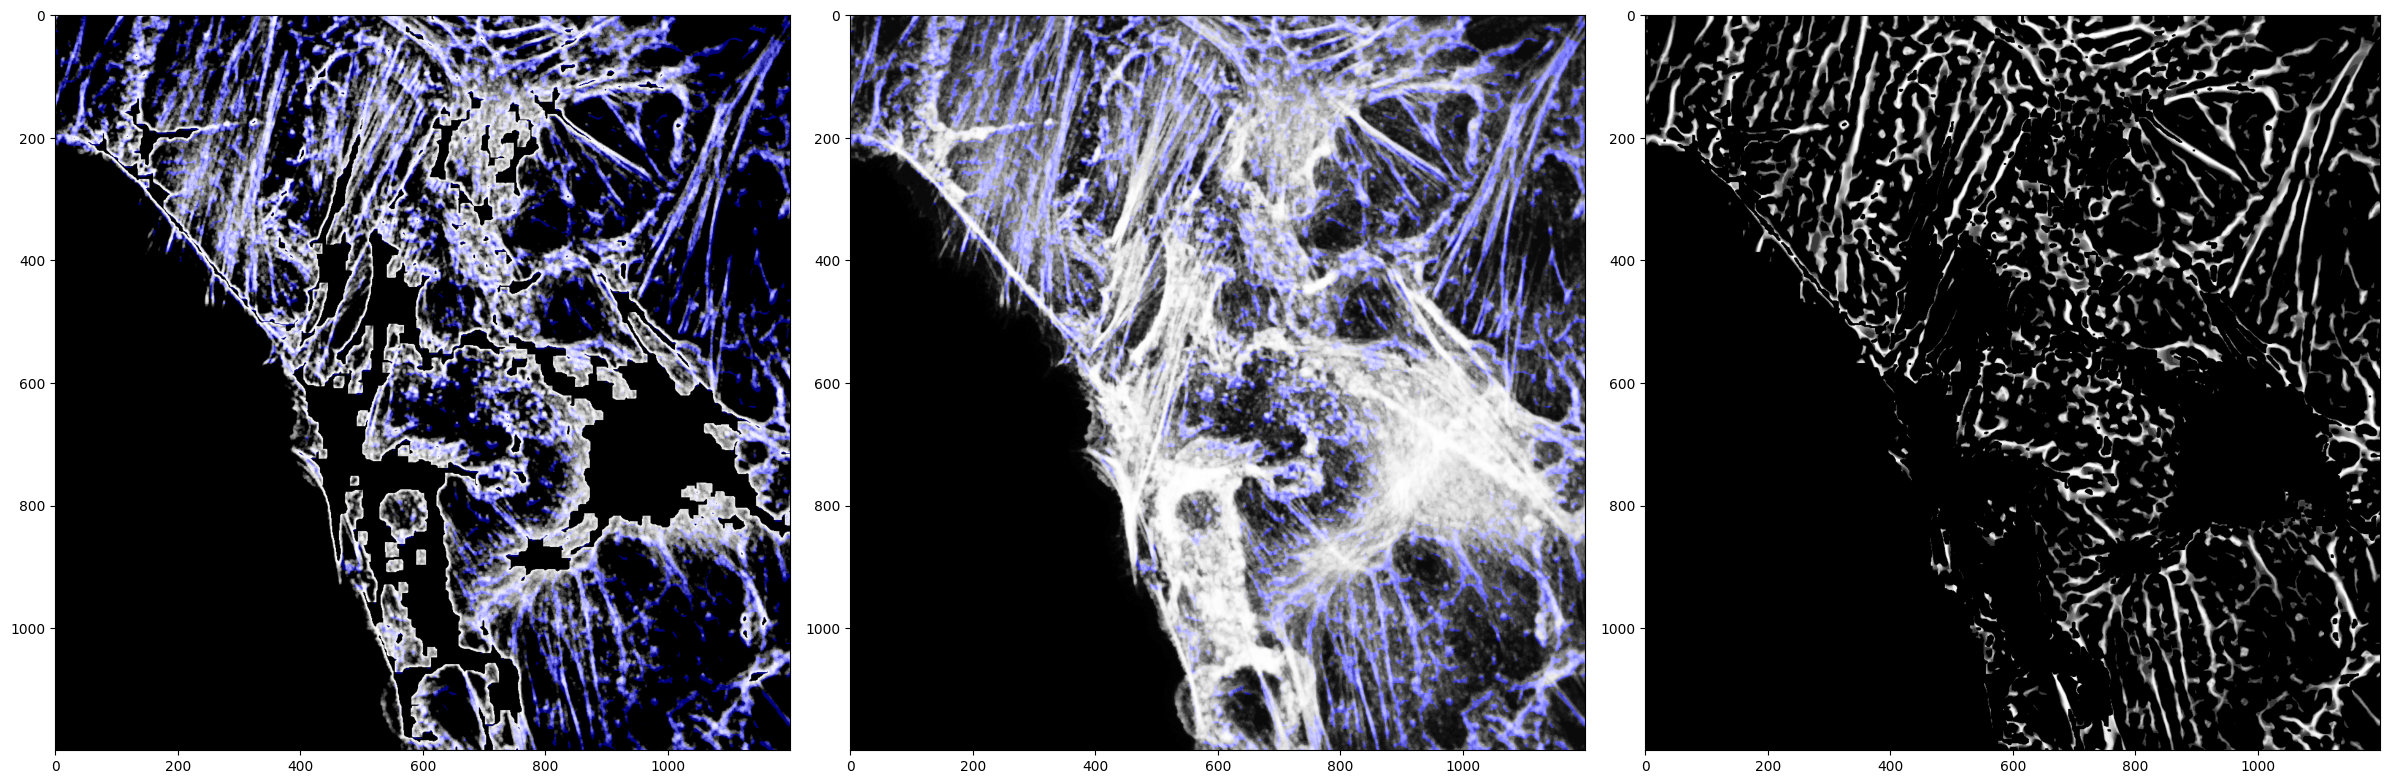

In [76]:
image4_func()